# Import Modules

In [4]:
import os

import numpy as np # Linear Algebra

import cv2

import random

# Visualization
import matplotlib.pyplot as plt

# TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, metrics
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, concatenate, Lambda, BatchNormalization

# Warnings
import warnings
warnings.filterwarnings("ignore")

## Limit GPU

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Load Data

In [12]:
class PreProcessing:

    def __init__(self, verbose=True):

        self.train_images = []
        self.val_images = []
        self.verbose = verbose
        self.train_path = "raw_data\images_background\images_background"
        self.val_path = "raw_data\images_evaluation\images_evaluation"
        self.train_images = self.load_image(self.train_path)
        self.val_images = self.load_image(self.val_path)


    def load_image(self, path):
        """
        This function loads images from a given directory path. It loads the images in grayscale and normalizes them.
        The images are organized by alphabet and letter, and are returned in a numpy array.
        
        Parameters:
        path (str): The directory path containing the images.
        
        Returns:
        X (numpy array): The normalized and loaded images in a numpy array.
        """
        X = []
        if self.verbose:
            print('Loading Image From this path - ', path)

        for alphabet in os.listdir(path):
            if self.verbose:
                print("Loading Alphabet as : ", alphabet)
            alphabet_path = os.path.join(path, alphabet)
            for letter in os.listdir(alphabet_path):
                letter_path = os.path.join(alphabet_path, letter)
                letter_images = []
                for filename in os.listdir(letter_path):
                    file_path = os.path.join(letter_path, filename)
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    img = np.reshape(img, (105, 105, 1))
                    img = img / 255
                    letter_images.append(img)
                try:
                    X.append(np.stack(letter_images))
                except ValueError as e:
                    print(e)
        X = np.stack(X)
        return X


    def get_triplet(self, shape):
        """
        A function that retrieves a triplet of anchor, positive and negative examples.
        
        Parameters:
        shape (tuple): A tuple containing the shape of the dataset (number of classes, number of examples per class)
        
        Returns:
        tuple: A tuple containing the indices of the anchor, positive and negative examples.
        """
        class_1 = random.randint(0, shape[0] - 1)
        class_2 = random.randint(0, shape[0] - 1)
        a, p = (class_1, random.randint(0, shape[1] - 1)), (class_1, random.randint(0, shape[1] - 1))
        n = (class_2, random.randint(0, shape[1] - 1))
        return a, p, n

    def get_triplet_batch(self, batch_size, train_data=True):
        """
        Generates a batch of triplet images from either the training or validation dataset.

        Parameters:
        batch_size (int): The number of triplets to generate.
        train_data (bool, optional): Whether to use the training dataset (True) or the validation dataset (False) for the triplets. Defaults to True.

        Returns:
        list: A list containing the anchor image, positive image, and negative image as numpy arrays.
        """
        anchor_image = []
        positive_image = []
        negative_image = []
        if train_data:
            X = self.train_images
        else:
            X = self.val_images

        for _ in range(batch_size):
            ida, idp, idn = self.get_triplet(X.shape)
            anchor_image.append(X[ida])
            positive_image.append(X[idp])
            negative_image.append(X[idn])

        ai = np.array(anchor_image)
        pi = np.array(positive_image)
        ni = np.array(negative_image)
        return [ai, pi, ni]

In [13]:
preprocess_data = PreProcessing(verbose=True)

Loading Image From this path -  raw_data\images_background\images_background
Loading Alphabet as :  Alphabet_of_the_Magi
Loading Alphabet as :  Anglo-Saxon_Futhorc
Loading Alphabet as :  Arcadian
Loading Alphabet as :  Armenian
Loading Alphabet as :  Asomtavruli_(Georgian)
Loading Alphabet as :  Balinese
Loading Alphabet as :  Bengali
Loading Alphabet as :  Blackfoot_(Canadian_Aboriginal_Syllabics)
Loading Alphabet as :  Braille
Loading Alphabet as :  Burmese_(Myanmar)
Loading Alphabet as :  Cyrillic
Loading Alphabet as :  Early_Aramaic
Loading Alphabet as :  Futurama
Loading Alphabet as :  Grantha
Loading Alphabet as :  Greek
Loading Alphabet as :  Gujarati
Loading Alphabet as :  Hebrew
Loading Alphabet as :  Inuktitut_(Canadian_Aboriginal_Syllabics)
Loading Alphabet as :  Japanese_(hiragana)
Loading Alphabet as :  Japanese_(katakana)
Loading Alphabet as :  Korean
Loading Alphabet as :  Latin
Loading Alphabet as :  Malay_(Jawi_-_Arabic)
Loading Alphabet as :  Mkhedruli_(Georgian)
Load

In [17]:
batch_size = 4
anchor_image, positive_image, negative_image = preprocess_data.get_triplet_batch(batch_size,train_data=False)

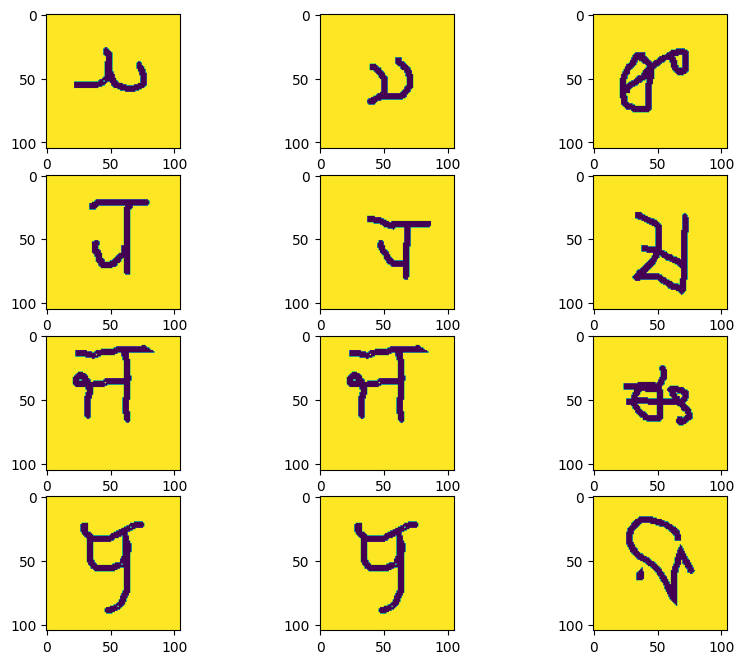

In [18]:
fig, ax = plt.subplots(nrows=batch_size, ncols=3,figsize=(10, 8))
for i in range(batch_size):
    ax[i, 0].imshow(np.reshape(anchor_image[i], (105, 105)))
    ax[i, 1].imshow(np.reshape(positive_image[i], (105, 105)))
    ax[i, 2].imshow(np.reshape(negative_image[i], (105, 105)))
plt.show()

# Model

In [19]:
emb_size = 128
emb_model = Sequential()
emb_model.add(Conv2D(64, (10,10), activation='relu', input_shape=(105, 105, 1)))
emb_model.add(BatchNormalization())
emb_model.add(MaxPooling2D())
emb_model.add(Dropout(0.5))
emb_model.add(Conv2D(32, (7,7), activation='relu'))
emb_model.add(BatchNormalization())
emb_model.add(MaxPooling2D())
emb_model.add(Dropout(0.5))
emb_model.add(Conv2D(64, (4,4), activation='relu'))
emb_model.add(BatchNormalization())
emb_model.add(Flatten())
emb_model.add(Dense(emb_size, activation='sigmoid'))
emb_model.add(Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=1)))

In [20]:
emb_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        6464      
                                                                 
 batch_normalization_3 (Batc  (None, 96, 96, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 48, 48, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 32)        100384    
                                                                 
 batch_normalization_4 (Batc  (None, 42, 42, 32)      

## Siamese Network

In [21]:
input_anc = Input(shape=(105,105,1))
input_pos = Input(shape=(105,105,1))
input_neg = Input(shape=(105,105,1))

emb_anc = emb_model(input_anc)
emb_pos = emb_model(input_pos)
emb_neg = emb_model(input_neg)

output = concatenate([emb_anc, emb_pos, emb_neg], axis=1)

siamese_network = Model([input_anc, input_pos, input_neg],output)

In [22]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                            

## Loss Function

In [26]:
def triplet_loss(alpha, emb_dim, cosine=False):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:, :emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
        distance1 = tf.sqrt(tf.reduce_sum(tf.pow(anc - pos, 2), 1, keepdims=True))
        distance2 = tf.sqrt(tf.reduce_sum(tf.pow(anc - neg, 2), 1, keepdims=True))
        return tf.reduce_mean(tf.maximum(distance1 - distance2 + alpha, 0.))
    return loss

In [27]:
def data_generator(batch_size, emb_size):
    while True:
        x = preprocess_data.get_triplet_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x,y

# Compile

In [28]:
batch_size = 128
epochs = 50
opt = tf.keras.optimizers.Adam(lr=0.001)
steps_per_epoch = 300
siamese_network.compile(loss=triplet_loss(alpha=0.2, emb_dim=emb_size,cosine=False), optimizer=opt)
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                            

In [29]:
history = siamese_network.fit(
    data_generator(batch_size, emb_size),
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    verbose=True
)

Epoch 1/50
300/300 [==============================] - 88s 256ms/step - loss: 0.0420
Epoch 2/50
300/300 [==============================] - 78s 260ms/step - loss: 0.0266
Epoch 3/50
300/300 [==============================] - 76s 254ms/step - loss: 0.0226
Epoch 4/50
300/300 [==============================] - 75s 251ms/step - loss: 0.0211
Epoch 5/50
300/300 [==============================] - 73s 245ms/step - loss: 0.0199
Epoch 6/50
300/300 [==============================] - 74s 247ms/step - loss: 0.0183
Epoch 7/50
300/300 [==============================] - 74s 247ms/step - loss: 0.0185
Epoch 8/50
300/300 [==============================] - 76s 254ms/step - loss: 0.0171
Epoch 9/50
300/300 [==============================] - 73s 244ms/step - loss: 0.0165
Epoch 10/50
300/300 [==============================] - 72s 239ms/step - loss: 0.0169
Epoch 11/50
300/300 [==============================] - 73s 242ms/step - loss: 0.0161
Epoch 12/50
300/300 [==============================] - 74s 246ms/step - lo

# Evaluation

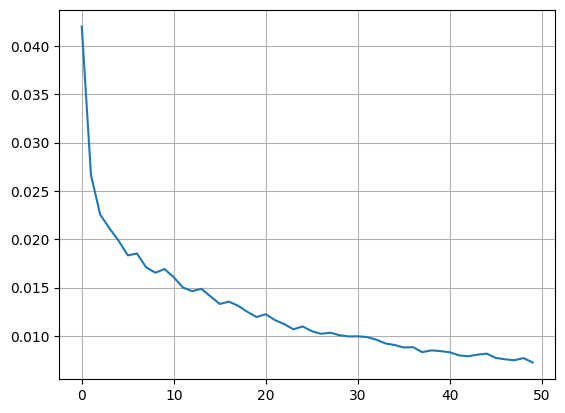

In [30]:
plt.plot(history.history['loss'], label='Loss')
plt.grid(True)
plt.show()

In [31]:
print(history.history['loss'])

[0.0419958159327507, 0.026649542152881622, 0.022561045363545418, 0.021139679476618767, 0.019853558391332626, 0.018338609486818314, 0.01852133683860302, 0.017092788591980934, 0.016540028154850006, 0.016920994967222214, 0.016064893454313278, 0.015008831396698952, 0.014635348692536354, 0.014876597560942173, 0.014085130766034126, 0.013313735835254192, 0.013549982570111752, 0.013122552074491978, 0.01249759178608656, 0.01196049153804779, 0.012254011817276478, 0.011637899093329906, 0.01122899167239666, 0.010692982003092766, 0.010987888090312481, 0.01050027646124363, 0.010226539336144924, 0.010337076149880886, 0.010083838365972042, 0.009952718392014503, 0.009967210702598095, 0.009885742329061031, 0.009620610624551773, 0.009231595322489738, 0.009067418985068798, 0.00881052017211914, 0.008847060613334179, 0.008328661322593689, 0.008514764718711376, 0.008433881215751171, 0.008316261693835258, 0.007998398505151272, 0.007904879748821259, 0.008068324998021126, 0.008177022449672222, 0.007729861885309

## Get Accuracies

In [32]:
test_sample = 150
nway_min = 5
nway_max = 25
test_acc = []
nway_list = []
for nway in range(nway_min, nway_max+1,5):
  print("Checking %d way accuracy...." % nway)
  correct_count = 0
  for _ in range(test_sample):
    nway_anchor, nway_positive, _ = preprocess_data.get_triplet_batch(nway, train_data=False)
    nway_anchor_embedding = emb_model.predict(nway_anchor)
    sample_index = random.randint(0,nway-1)
    sample_embedding = emb_model.predict(np.expand_dims(nway_positive[sample_index], axis=0))
    distance = tf.sqrt(tf.reduce_sum(tf.pow(nway_anchor_embedding - sample_embedding, 2), 1, keepdims=True)).numpy()
    if np.argmin(distance) == sample_index:
      correct_count+=1
  nway_list.append(nway)
  acc = (correct_count/test_sample)*100.
  test_acc.append(acc)
  print("Accuracy %.2f" % acc)

Checking 5 way accuracy....
1/1 [==============================] - 0s 15ms/step
Accuracy 94.00
Checking 10 way accuracy....
1/1 [==============================] - 0s 19ms/step
Accuracy 85.33
Checking 15 way accuracy....
1/1 [==============================] - 0s 14ms/step
Accuracy 84.67
Checking 20 way accuracy....
1/1 [==============================] - 0s 17ms/step
Accuracy 80.67
Checking 25 way accuracy....
1/1 [==============================] - 0s 24ms/step
Accuracy 75.33


In [33]:
test_sample = 150
nway_min = 5
nway_max = 25
train_acc = []
nway_list = []
for nway in range(nway_min, nway_max+1,5):
  print("Checking %d way accuracy...." % nway)
  correct_count = 0
  for _ in range(test_sample):
    nway_anchor, nway_positive, _ = preprocess_data.get_triplet_batch(nway, train_data=True)
    nway_anchor_embedding = emb_model.predict(nway_anchor)
    sample_index = random.randint(0,nway-1)
    sample_embedding = emb_model.predict(np.expand_dims(nway_positive[sample_index], axis=0))
    distance = tf.sqrt(tf.reduce_sum(tf.pow(nway_anchor_embedding - sample_embedding, 2), 1, keepdims=True)).numpy()
    if np.argmin(distance) == sample_index:
      correct_count+=1
  nway_list.append(nway)
  acc = (correct_count/test_sample)*100.
  train_acc.append(acc)
  print("Accuracy %.2f" % acc)

Checking 5 way accuracy....
1/1 [==============================] - 0s 15ms/step
Accuracy 98.67
Checking 10 way accuracy....
1/1 [==============================] - 0s 14ms/step
Accuracy 92.67
Checking 15 way accuracy....
1/1 [==============================] - 0s 16ms/step
Accuracy 90.00
Checking 20 way accuracy....
1/1 [==============================] - 0s 16ms/step
Accuracy 96.00
Checking 25 way accuracy....
1/1 [==============================] - 0s 18ms/step
Accuracy 84.67


# N Way Accuracy Plot

<function matplotlib.pyplot.show(close=None, block=None)>

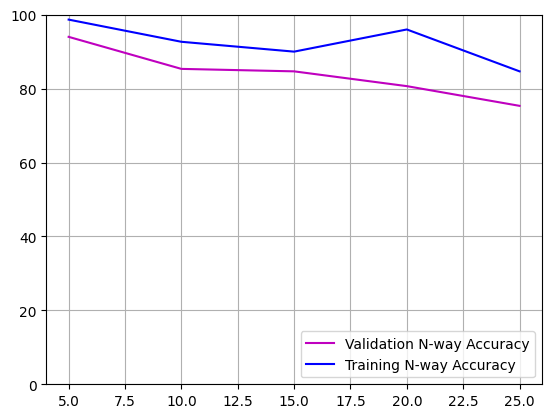

In [36]:
plt.plot(nway_list, test_acc, 'm', label='Validation N-way Accuracy')
plt.plot(nway_list, train_acc, 'b', label='Training N-way Accuracy')
plt.axis([None, None, 0, 100])
plt.grid(True)
plt.legend(loc='lower right')
plt.show